## Feature Engineering

In [66]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder



warnings.filterwarnings('ignore')

In [67]:
sns.set_style("darkgrid")

### 1 - Loading dataset

In [68]:
df = pd.read_csv('../data/Titanic-Dataset.csv')

df.shape

(891, 12)

In [69]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

| Coluna                  | Descrição                                                            |
|-------------------------|----------------------------------------------------------------------|
| id                      | Número da conta                                                      |
| default                 | Indica se o cliente é adimplente (0) ou inadimplente (1)            |
| idade                   | ---                                                                  |
| sexo                    | ---                                                                  |
| dependentes             | ---                                                                  |
| escolaridade            | ---                                                                  |
| estado_civil            | ---                                                                  |
| salario_anual           | Faixa do salário mensal multiplicado por 12                        |
| tipo_cartao             | Categoria do cartão: blue, silver, gold e platinium                 |
| meses_de_relacionamento | Quantidade de meses desde a abertura da conta                       |
| qtd_produtos            | Quantidade de produtos contratados                                   |
| iteracoes_12m           | Quantidade de interações com o cliente no último ano                |
| meses_inativo_12m       | Quantidade de meses que o cliente ficou inativo no último ano       |
| limite_credito          | Valor do limite do cartão de crédito                                 |
| valor_transacoes_12m   | Soma total do valor das transações no cartão de crédito no último ano |
| qtd_transacoes_12m     | Quantidade total de transações no cartão de crédito no último ano   |


In [70]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [71]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [72]:
# drop unnecessary variables
df.drop(['Name', 'PassengerId'], axis=1, inplace=True, errors='ignore')

df.columns


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

### 2 - Data Exploration

In [73]:
df_nan_rations = df.isna().sum()
df_nan_rations

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

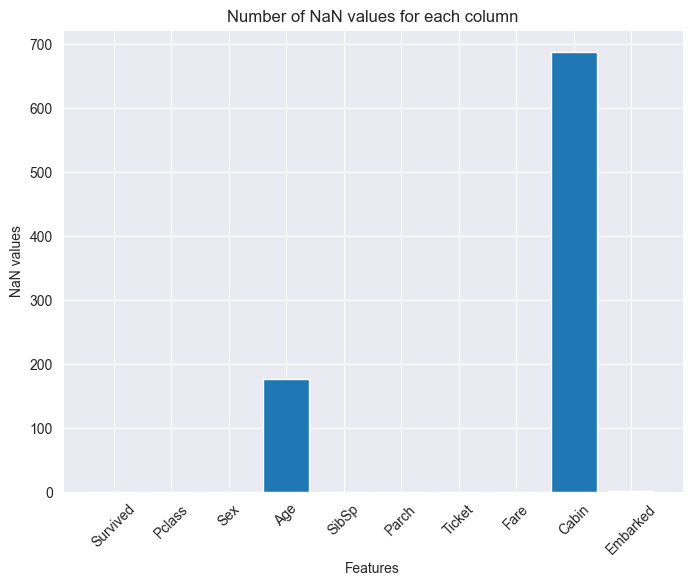

In [74]:
x_bar = np.arange(len(df_nan_rations.index))

plt.bar(x_bar, df_nan_rations.values)
plt.xticks(x_bar, df_nan_rations.index, rotation=45)
plt.xlabel("Features")
plt.ylabel("NaN values")
plt.title('Number of NaN values for each column')
plt.show()

In [75]:
missing_features = df_nan_rations[df_nan_rations.values > 0]
missing_features

Age         177
Cabin       687
Embarked      2
dtype: int64

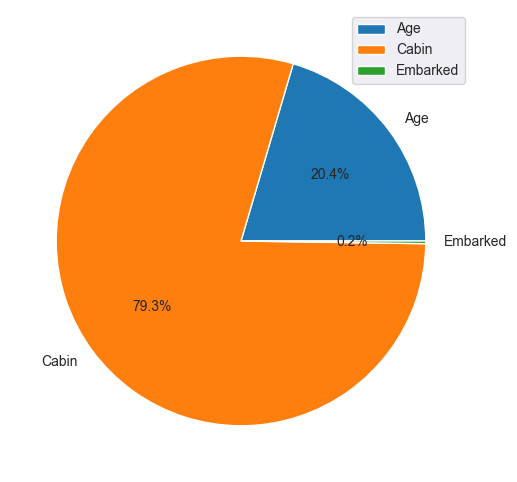

In [76]:
plt.pie(missing_features.values / df.shape[0], labels=missing_features.index, autopct='%1.1f%%')
plt.legend()
plt.show()

In [77]:
ser_count = df['Survived'].value_counts()
ser_count

Survived
0    549
1    342
Name: count, dtype: int64

In [78]:
list_survived_ratio = [ser_count[idx]/df.shape[0] for idx in ser_count.index]
print(list_survived_ratio)

[np.float64(0.6161616161616161), np.float64(0.3838383838383838)]


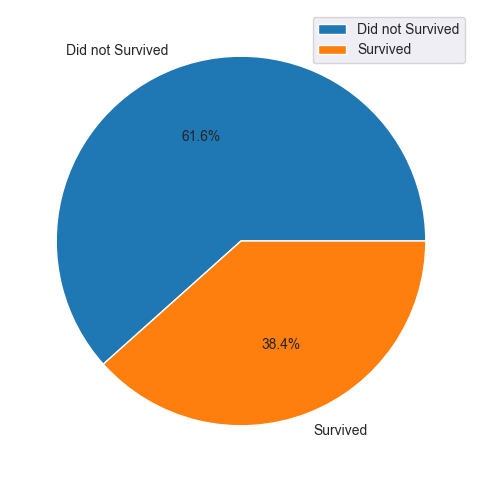

In [79]:
plt.pie(list_survived_ratio, labels=['Did not Survived', 'Survived'], autopct='%1.1f%%')
plt.legend()
plt.show()


Evaluating variable distribution and determining the need for  transformation, based on the following criteria

- Decision Making Workflow
    - Visualize Original Distribution
    - Check Skewness and Kurtosis
    - Evaluate Transformation Candicates
    - Select Appropriate Transformation
    - Apply Transformation impact
- Pratical Recommendations
    - **Log Transformation**: Right-skwed data
    - **Square Root**: Moderately skwed data
    - **Yo-Johnson:** handles negative values, mode flexible
- Key Metrics to Consider
    - Skewness: Asymmetry ofdistribution
        - Near 0: Symmetrical
        - 1 or < -1: Highly skwed
    - Kurtosis: Tail heaviness
        - Near 0: Normal distribution
        - 3: Heavy-tailed
        - < 3: Light-tailed

NOTE: This session bridges the visualization and data preparation phases, providing a structured approach to evaluate and apply transformations effectively.

- Transformations are not always necessary
- Consider algorithm sentivity
- Validate model performance before and after transformation
- Use cross-validation to ensure transformation benefit

In [90]:
def analyze_distribution(df, column):
    plt.figure(figsize=(15, 10))

    # Original Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Original Distribution: {column}')

    plt.subplot(2, 2, 2)
    sns.boxplot(x=df[column])
    plt.title('Box Plot')

    # Q-Q Plot (Normality Check)
    plt.subplot(2, 2, 3)
    stats.probplot(df[column], plot=plt)
    plt.title('Q-Q Plot')

    # Descritive Statistics
    plt.subplot(2, 2, 4)
    plt.text(0.1, 0.5,
            f'Skewness: {df[column].skew():.2f}\n'
            f'Kurtosis: {df[column].kurtosis():.2f}\n'
            f'Min: {df[column].min():.2f}\n'
            f'Max: {df[column].max():.2f}\n'
            f'Mean: {df[column].mean():.2f}\n'
            f'Median: {df[column].median():.2f}',
            fontsize=10)
    plt.axis('off')
    plt.title('Descriptive Statistics')

    plt.tight_layout()
    plt.show()

def evaluate_transformations(df, column):
    """Transformation Candidates"""
    plt.figure(figsize=(15, 5))

    # Original Distritution
    plt.subplot(141)
    sns.histplot(df[column], kde=True)
    plt.title(f'Original distribution {column}')

    # Log Transformation
    plt.subplot(142)
    sns.histplot(np.log1p(df[column]), kde=True)
    plt.title('Log (log(x+1))')

    # Square Root Transformation
    plt.subplot(143)
    sns.histplot(np.sqrt(df[column]), kde=True)
    plt.title('Square Root')

    # Box-Cox Transformation
    plt.subplot(144)
    try:
        transformed_data = stats.boxcox(df[column])[0]
        sns.histplot(transformed_data, kde=True)
        plt.title('Box-Cox')
    except:
        plt.text(0.5, 0.5, 'Box-Cox\nNot Applicable',
                 horizontalalignment='center',
                 verticalalignment='center')
    plt.tight_layout()
    plt.show()

Statistical Criteria for Transformation (Preparation Phase)

In [106]:
def determine_transformation(df, column, threshold =1):
    skewness = df[column].skew()
    kurtosis = df[column].kurtosis()

    print('Distribution Assessment:')
    print(f'Skewness: {skewness:.2f}')
    print(f'Kurtosis: {kurtosis:.2f}')

    transformation_needed = False
    recommendation = 'No transformation'

    if abs(skewness) > threshold:
        transformation_needed = True
        recommandation = 'Log or Square Root Transformation'

    if abs(kurtosis) > threshold:
        transformation_needed = True
        recommandation_needed = 'Box-Cox or Yeo-Johnson Transformation'
    print(f'Recommandation: {recommendation}')
    return transformation_needed, recommendation


def apply_transformation(df, column, method='log'):
    if method == 'log':
        return np.log1p(df[column])
    elif method == 'sqrt':
        return np.sqrt(df[column])
    elif method == 'box-cox':
        return stats.boxcox(df[column])[0]
    elif method == 'yeo-johnson':
        transformer = PowerTransformer(method='yeo-johnson')
        return transformer.fit_transform(data[[column]]).flatten()
        

### Evaluating variable distribution

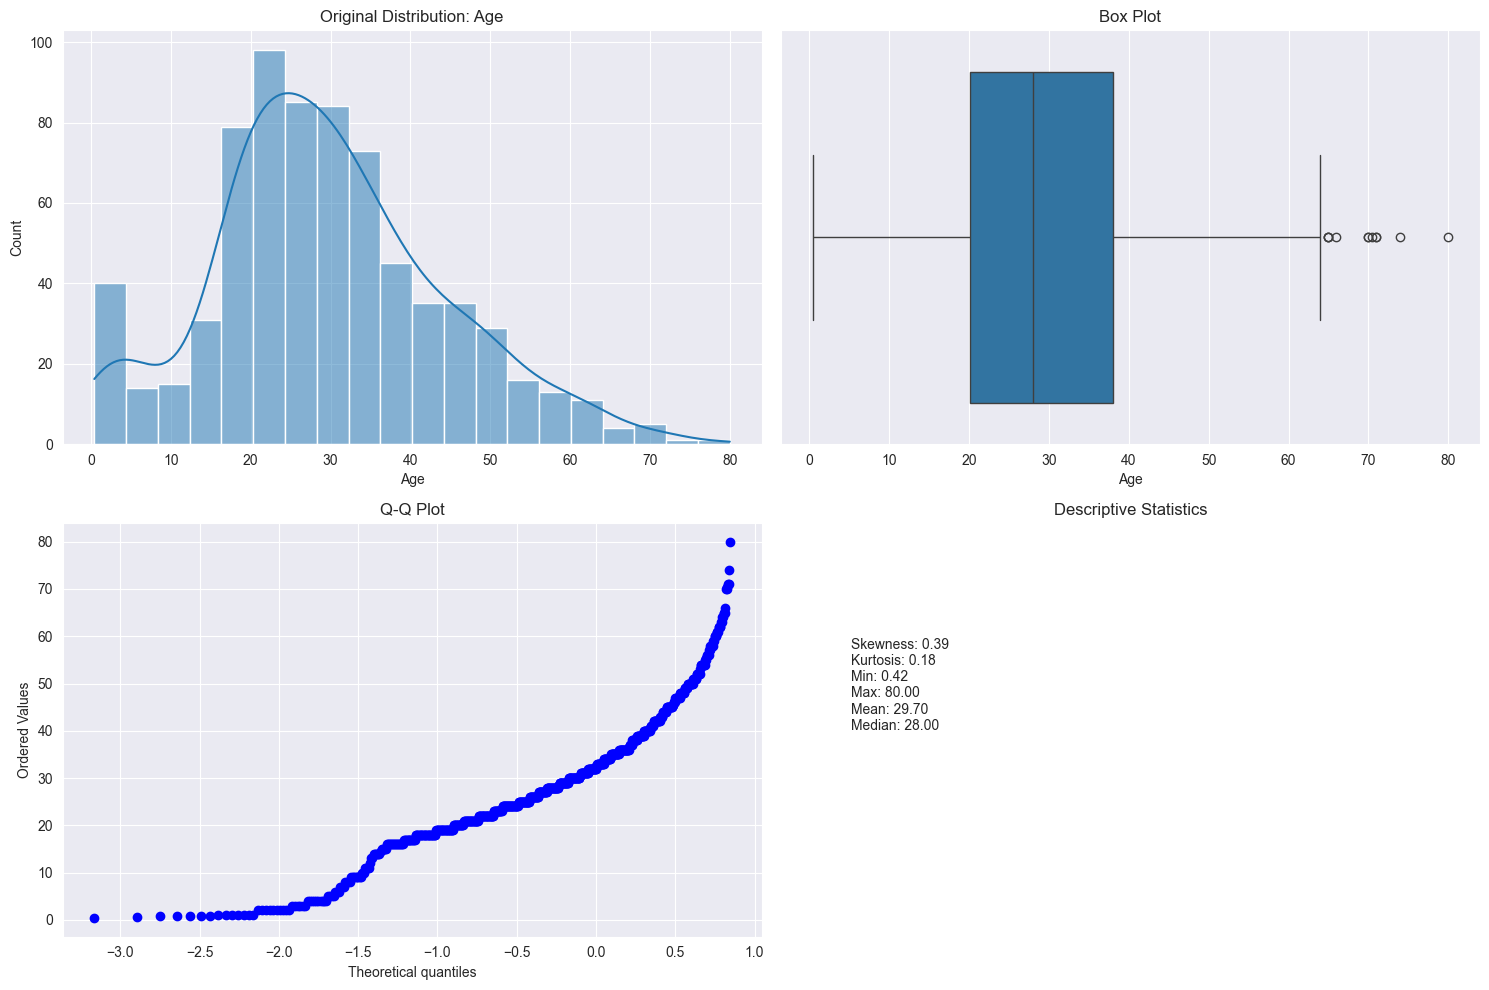

In [107]:
analyze_distribution(df, 'Age')

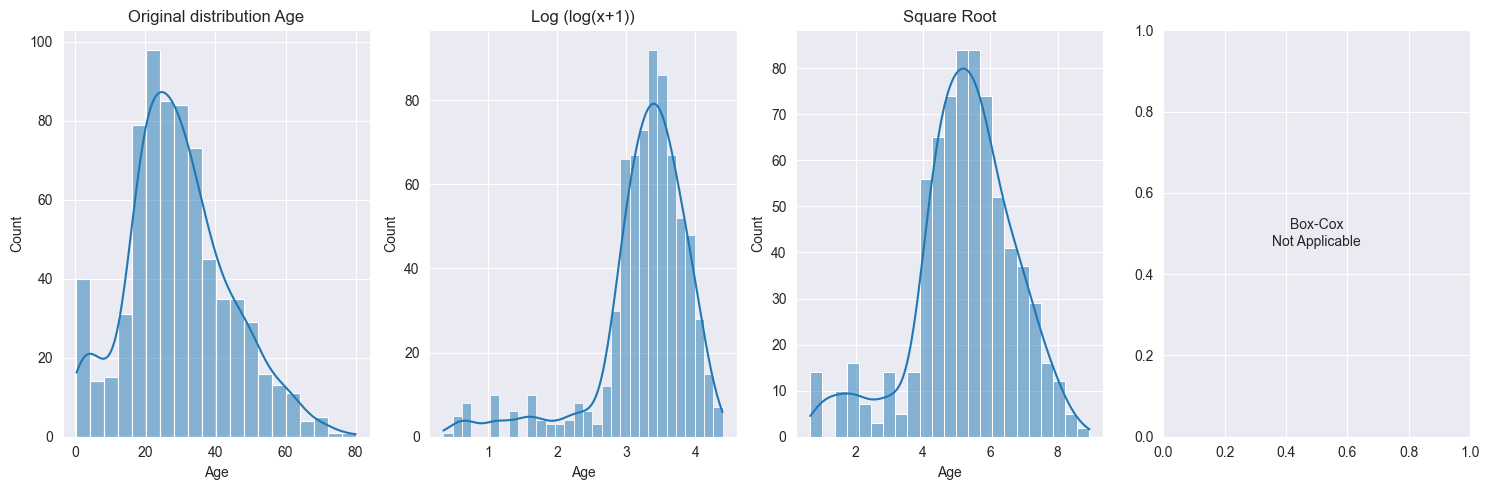

In [108]:
evaluate_transformations(df, 'Age')

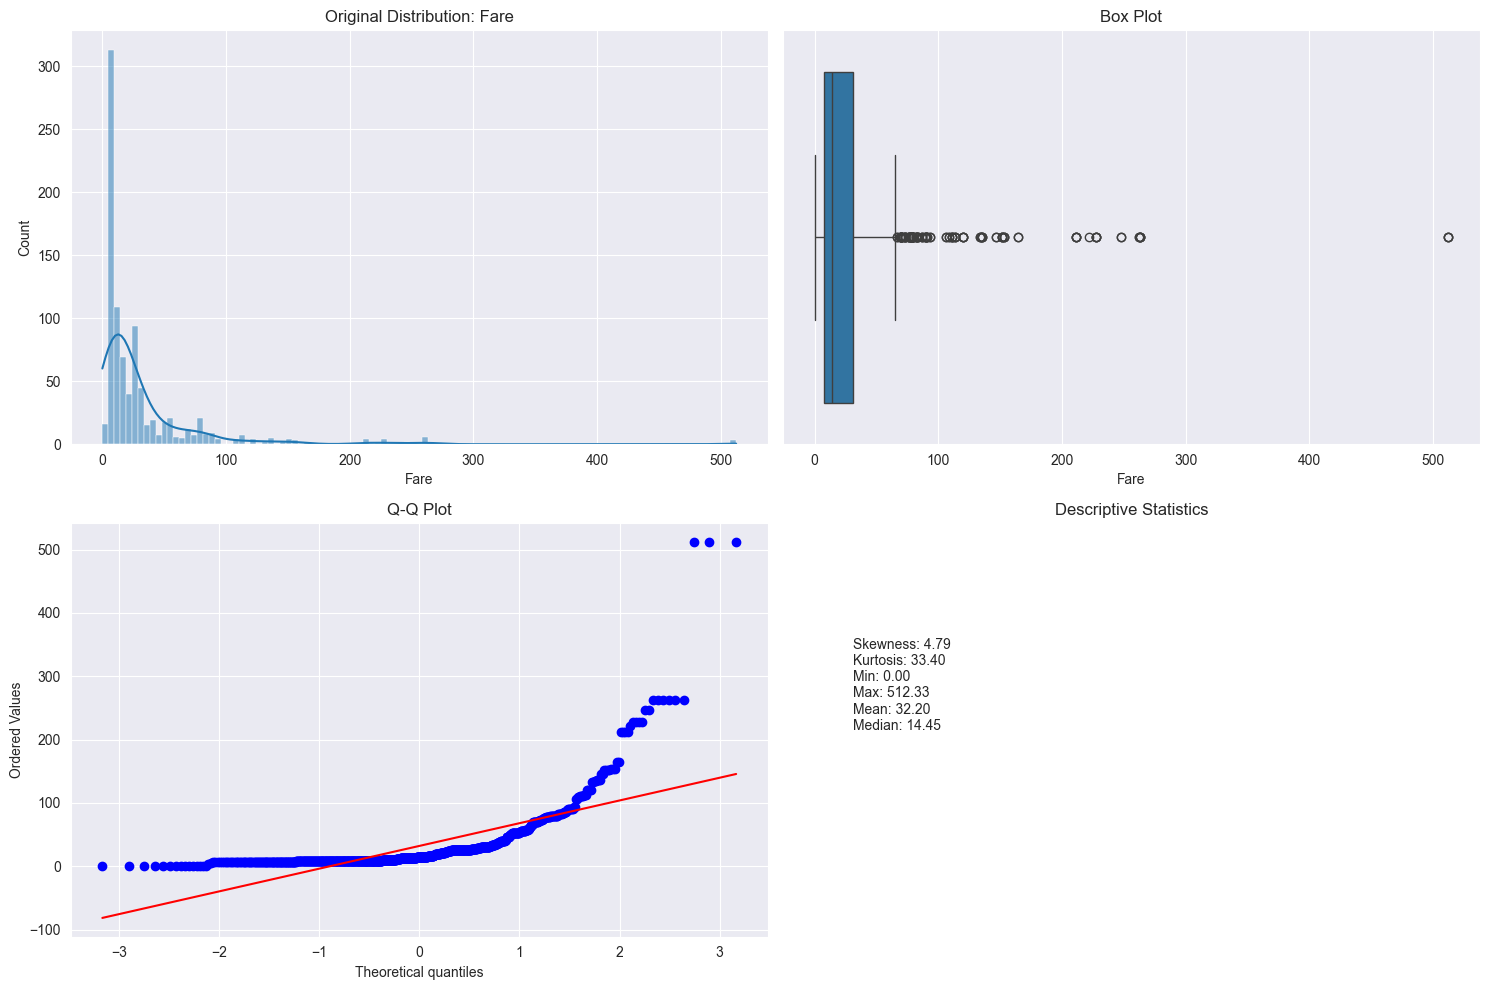

In [109]:
analyze_distribution(df, 'Fare')

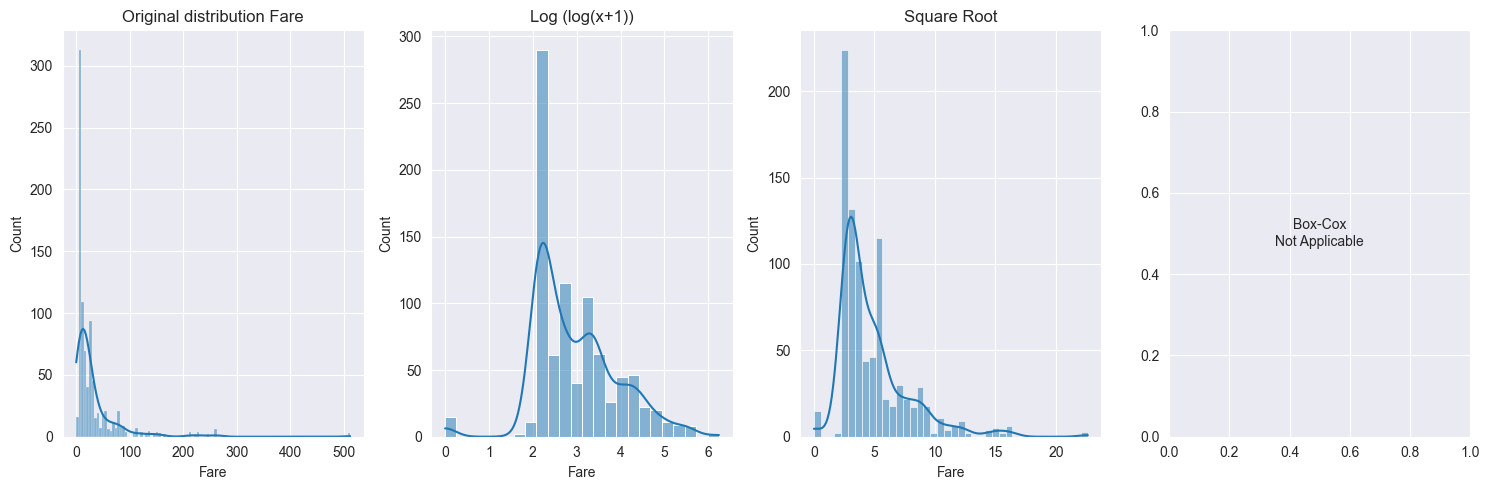

In [110]:
evaluate_transformations(df, 'Fare')

### determining the need for  transformation

In [111]:
is_transformation_needed, recommandation = determine_transformation(df, 'Age')

if is_transformation_needed:
    df['transformation_feature'] = apply_transformation(df, 'Age', method='log')

Distribution Assessment:
Skewness: 0.39
Kurtosis: 0.18
Recommandation: No transformation


In [112]:
is_transformation_needed, recommandation = determine_transformation(df, 'Fare')

if is_transformation_needed:
    df['transformation_feature'] = apply_transformation(df, 'Fare', method='log')

Distribution Assessment:
Skewness: 4.79
Kurtosis: 33.40
Recommandation: No transformation


### 2 - Data Preparation

### 2. 1 Imputing missing Data

In [14]:
# Perfoming mean or median imputation

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Survived'], axis=1), df['Survived'], test_size=0.3, random_state=0)

In [15]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
857,1,male,51.0,0,0,113055,26.5500,E17,S
52,1,female,49.0,1,0,PC 17572,76.7292,D33,C
386,3,male,1.0,5,2,CA 2144,46.9000,NaN,S
124,1,male,54.0,0,1,35281,77.2875,D26,S
578,3,female,NaN,1,0,2689,14.4583,NaN,C


In [16]:
y_train.head()

857    1
52     1
386    0
124    0
578    0
Name: Survived, dtype: int64

### Imputing numerical variables

Let's make a list of numerical variables by excluding variable of type object

In [17]:
numerical_vars = X_train.select_dtypes(exclude='O').columns.to_list()
numerical_vars

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [18]:
# Filter numerical variables to inclucde only those with missing values
numerical_vars_with_na = [var for var in numerical_vars if X_train[var].isnull().sum() > 0]
numerical_vars_with_na

['Age']

In [19]:
imputer = MeanMedianImputer(
    imputation_method='median',
    variables=numerical_vars_with_na
)

imputer.fit(X_train)
imputer.imputer_dict_

{'Age': 29.0}

In [20]:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [21]:
X_train[numerical_vars].isnull().mean()

Pclass    0.0
Age       0.0
SibSp     0.0
Parch     0.0
Fare      0.0
dtype: float64

### Imputing categorical variables

Let's make a list of categorical variables

In [22]:
categorical_vars = X_train.select_dtypes(include='O').columns.to_list()
categorical_vars

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [23]:
# Filter categorical variables to include only those with missing values
categorical_with_na = [var for var in categorical_vars if X_train[var].isnull().sum() > 0]
categorical_with_na

['Cabin', 'Embarked']

In [24]:
"""
Since The variable(s) Cabin contain(s) multiple frequent categories, We need to separate Cabin from
other categorical variables
"""


imputer = CategoricalImputer(
    imputation_method='missing',
    variables=categorical_with_na
)

imputer.fit(X_train)
imputer.imputer_dict_

{'Cabin': 'Missing', 'Embarked': 'Missing'}

In [25]:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [26]:
X_train[categorical_vars].isnull().mean()

Sex         0.0
Ticket      0.0
Cabin       0.0
Embarked    0.0
dtype: float64

In [27]:
# chech if we still we na vars
X_train.isnull().mean()

Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64

In [28]:
# check if we stilll na vars
X_test.isnull().mean()

Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64

### 2.2 Encoding Categorical Variables

In [212]:
ohe_enc = OneHotEncoder(drop_last=True, variables=categorical_vars)

ohe_enc.fit(X_train)
ohe_enc.variables_



['Sex', 'Ticket', 'Cabin', 'Embarked']

In [213]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

In [214]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Ticket_113055,Ticket_PC 17572,Ticket_CA 2144,Ticket_35281,...,Cabin_C70,Cabin_F E69,Cabin_C86,Cabin_D48,Cabin_C49,Cabin_A7,Cabin_A20,Embarked_S,Embarked_C,Embarked_Q
857,1,51.0,0,0,26.5500,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52,1,49.0,1,0,76.7292,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
386,3,1.0,5,2,46.9000,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
124,1,54.0,0,1,77.2875,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
578,3,29.0,1,0,14.4583,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [217]:
print('Number of features: ', len(X_train.index))

Number of features:  623


In [ ]:
X_train.isnull().mean()

### 2.3 Transforming Numerical variables

To evaluate the variable distribution and understand whether a transformation improves value spread